In [1]:
import gauleg as gl 
import sympy as sp 
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt
np.random.seed(12345)

#####################################
###### INITIALISING PARAMETERS ######
#####################################

# def a0(x):
#     return 2 + math.sin(2*math.pi *x)

# def a0(x):
#     if 0 <= x < xd:
#         return 1
#     elif 0.5 <= x <= 1:
#         return 2

import numpy as np

def a0(x, beta):
    """
    Computes the coefficient a0 at points x using the parameter beta.
    
    Parameters:
        x (array-like): Spatial coordinates.
        beta (tuple): (x_star, r) where x_star is the center of the interval 
                      and r is the half-width of the interval.
    
    Returns:
        np.array: Coefficient values; 2 if x is inside the interval, 1 otherwise.
    """
    x_star, r = beta
    x = np.asarray(x)
    return np.where((x >= (x_star - r)) & (x <= (x_star + r)), 2.0, 1.0)


# def f(x, beta):
#     x = np.asarray(x)
#     return a0(x, beta) * np.pi**2 * np.sin(np.pi * x)
def f(x, beta):
    x = np.asarray(x)
    return np.ones_like(x)

n2 =5

####################################
######### HELPER FUNCTIONS #########
####################################

    
# helper functions
def GL(x_left, x_right, func):
    # Ensure xi and ci are NumPy arrays:
    xi, ci = np.polynomial.legendre.leggauss(n2)
    # Map the nodes from [-1,1] to [x_left, x_right]
    x_mapped = 0.5 * ((x_right - x_left) * xi + (x_right + x_left))
    # Evaluate the integrand at all mapped nodes (func must be vectorized or accept an array)
    integrand_values = func(x_mapped)
    # Compute the weighted sum using a dot-product and return the scaled result.
    return 0.5 * (x_right - x_left) * np.dot(ci, integrand_values)

def piecewise_GL(integrand, x_left, x_right, discont_points=None):
    """
    Integrate 'integrand(x)' from x_left to x_right using Gauss-Legendre quadrature,
    splitting the integration at any discontinuity points provided in discont_points.
    
    Parameters:
      integrand      : function to integrate, which must accept a NumPy array.
      x_left, x_right: the endpoints of the integration interval.
      n2             : number of Gauss–Legendre quadrature points.
      discont_points : a list (or scalar) of discontinuity points in (x_left, x_right).
                       If None or empty, no splitting is performed.
    
    Returns:
      The value of the integral.
    """
    # If no discontinuity is provided, do a single integration.
    if discont_points is None or len(discont_points) == 0:
        return GL(x_left=x_left, x_right=x_right, func=integrand)
    
    # Ensure discont_points is a list; if it's a scalar, convert it.
    if not isinstance(discont_points, (list, tuple, np.ndarray)):
        discont_points = [discont_points]
    
    # Filter out those discontinuity points that lie within (x_left, x_right)
    splits = [p for p in discont_points if x_left < p < x_right]
    
    # Build the list of subinterval endpoints
    pts = [x_left] + sorted(splits) + [x_right]
    
    # Integrate over each subinterval and sum the results.
    total = 0.0
    for i in range(len(pts) - 1):
        total += GL(x_left=pts[i], x_right=pts[i+1], func=integrand)
    return total

def dphi_i_on_element(i, k, xlist):
    """
    Return the (constant) slope of the i-th shape function on the k-th subinterval
    [ x_k, x_{k+1} ] in a 1D mesh with nodes x_0 < ... < x_N.
    """
    if i == k:
        # node i is the left endpoint of the subinterval => slope from 1 at x_k down to 0 at x_{k+1}
        dx = xlist[k+1] - xlist[k]
        return -1.0 / dx
    elif i == k+1:
        # node i is the right endpoint => slope from 0 at x_k up to 1 at x_{k+1}
        dx = xlist[k+1] - xlist[k]
        return +1.0 / dx
    else:
        return 0.0
def phi_i(i, x, mesh):
    """
    Standard 1D hat (finite element) function.
    This returns the value of the i-th hat function at x, given a mesh.
    """
    x = np.asarray(x)  # Ensure x is a NumPy array.
    N = len(mesh) - 1  # Number of elements; nodes are 0,1,...,N.
    
    if i == 0:
        # For the left boundary, phi_0 is nonzero on [mesh[0], mesh[1]]
        cond = (x >= mesh[0]) & (x <= mesh[1])
        return np.where(cond, (mesh[1] - x) / (mesh[1] - mesh[0]), 0.0)
    
    elif i == N:
        # For the right boundary, phi_N is nonzero on [mesh[N-1], mesh[N]]
        cond = (x >= mesh[N-1]) & (x <= mesh[N])
        return np.where(cond, (x - mesh[N-1]) / (mesh[N] - mesh[N-1]), 0.0)
    
    else:
        # For an interior node i, the support is [mesh[i-1], mesh[i+1]]
        cond = (x >= mesh[i-1]) & (x <= mesh[i+1])
        # On the left subinterval [mesh[i-1], mesh[i]]
        left_cond = (x >= mesh[i-1]) & (x <= mesh[i])
        left_val = (x - mesh[i-1]) / (mesh[i] - mesh[i-1])
        # On the right subinterval (mesh[i], mesh[i+1]]
        right_cond = (x > mesh[i]) & (x <= mesh[i+1])
        right_val = (mesh[i+1] - x) / (mesh[i+1] - mesh[i])
        # Combine the two pieces:
        val = np.where(left_cond, left_val, np.where(right_cond, right_val, 0.0))
        return np.where(cond, val, 0.0)


def assemble_nodal_values(C):
    C = np.asarray(C) # Make sure C is 1D.
    return np.concatenate(([[0.0]], C, [[0.0]]))


def get_discont_points(x_left, x_right, beta):
    """
    Compute the discontinuity points for the coefficient a0(x, beta) on the interval [x_left, x_right].

    Parameters:
      x_left, x_right : float
          Endpoints of the integration interval.
      beta : tuple
          (x_star, r), where the discontinuity endpoints are x_star - r and x_star + r.
    
    Returns:
      A list of discontinuity points (subset of [x_star - r, x_star + r]) that lie in (x_left, x_right).
    """
    x_star, r_val = beta
    pts = []
    p1 = x_star - r_val
    p2 = x_star + r_val
    if x_left < p1 < x_right:
        pts.append(p1)
    if x_left < p2 < x_right:
        pts.append(p2)
    return pts


def solve_scF_once(mesh, beta):
    """
    Build and solve the system S*C = F for a single iteration.

    Parameters
    ----------
    n_list, m_list : lists of indices (e.g. polynomial degrees)
    i_list         : indices for the piecewise-constant or piecewise-linear basis

    Returns
    -------
    C : Sympy Matrix
        The solution vector for the unknowns.
    """
    a0_with_beta = lambda x: a0(x, beta)

    S0_mat = S0_ji(a0_with_beta, mesh, beta)         # Possibly a Sympy matrix
    fvect = build_force_vector(f, mesh, 5, beta)  # Possibly a Sympy matrix

    
    # Extract interior (numerical slicing)
    S_int = S0_mat[1:-1, 1:-1]
    F_int = fvect[1:-1, :]
    c_sol = np.linalg.solve(S_int.T, F_int) 

    return c_sol, fvect

def refinement_loop(epsilon, beta):
    """
    1) Start with initial mesh
    2) Solve once
    3) Estimate errors
    4) If all errors < epsilon, done. Else refine, go back to step 2.
    """
    ddof_list = []
    approximation_list = []
    mesh = np.linspace(0.0, 1.0, 5).tolist()
    ddof = len(mesh) - 2

    iteration_index = 0
    while iteration_index < 30:
        # Solve for c_sol on the current mesh
        c_sol, f_sol = solve_scF_once(mesh=mesh, beta = beta)

        nodal = assemble_nodal_values(c_sol)
        approximation = nodal.T @ f_sol
        approximation_list.append(approximation)

        # Estimate the elementwise errors
        errors = sum_of_error_list(mesh=mesh, nodal=nodal, beta= beta)

        # Mark which elements to refine
        # elements_to_refine = element_selection(errors=errors, epsilon=epsilon)
        elements_to_refine = dorfler_marking(errors, 0.5)

        # If no elements exceed threshold => done
        if not elements_to_refine:
            break
        # Refine the mesh only on the marked elements.
        new_mesh = element_refinement(mesh, elements_to_refine)

        if new_mesh == mesh:
            print("Mesh did not change upon refinement. Terminating.")
            break
        mesh = new_mesh
        iteration_index += 1
        ddof += len(new_mesh) - 2
        ddof_list.append(ddof)

    true_approximation = approximation_list[-1].item()
    error_list = []
    for u_i in approximation_list:
        error = true_approximation - u_i.item()
        error_list.append(error)

    # After loop, final solution is c_sol on final mesh
    # Return everything, including the entire history
    return mesh, c_sol, ddof_list, error_list, true_approximation


###################################
####### ASSEMBLY OF MATRIX  #######
###################################

# assembly of matrix S0 and F
def S0_ji(func, mesh, beta):
    """
    Assemble the stiffness matrix S0 using the coefficient function 'func' (which is beta-aware)
    and the mesh. The integration splits at the discontinuity points derived from beta.
    """
    N = len(mesh)
    S0_mat = np.zeros((N, N), dtype=float)

    # Assembly of diagonal entries:
    for j in range(N):
        diag_val = 0.0
        # Contribution from the left subinterval [mesh[j-1], mesh[j]]
        if j > 0:
            x_left = mesh[j-1]
            x_right = mesh[j]
            def integrand_left(x):
                return func(x) * (dphi_i_on_element(j, j-1, mesh))**2
            diag_val += piecewise_GL(integrand_left, x_left, x_right,
                                      discont_points=get_discont_points(x_left, x_right, beta))
        # Contribution from the right subinterval [mesh[j], mesh[j+1]]
        if j < N-1:
            x_left = mesh[j]
            x_right = mesh[j+1]
            def integrand_right(x):
                return func(x) * (dphi_i_on_element(j, j, mesh))**2
            diag_val += piecewise_GL(integrand_right, x_left, x_right,
                                      discont_points=get_discont_points(x_left, x_right, beta))
        S0_mat[j, j] = diag_val

    # Assembly of off-diagonal entries:
    for j in range(1, N):
        x_left = mesh[j-1]
        x_right = mesh[j]
        def integrand_off(x):
            return func(x) * dphi_i_on_element(j-1, j-1, mesh) * dphi_i_on_element(j, j-1, mesh)
        val = piecewise_GL(integrand_off, x_left, x_right,
                           discont_points=get_discont_points(x_left, x_right, beta))
        S0_mat[j, j-1] = val
        S0_mat[j-1, j] = val  # Exploiting symmetry
    
    return S0_mat


def build_force_vector(f, mesh, n2=5, beta=None):
    """
    Assemble the force (load) vector F where
         F[i] = ∫ f(x, beta) * phi_i(x, mesh) dx,
    splitting the integration at the discontinuity points derived from beta.
    
    Parameters:
      f     : The source function, which now depends on beta.
      mesh  : List of node coordinates.
      n2    : Number of Gauss-Legendre points (if used in GL).
      beta  : Parameter tuple (x_star, r) used in f.
      
    Returns:
      F : A column vector (Sympy Matrix) of size (N+1) x 1.
    """
    num_nodes = len(mesh)
    F = np.zeros((num_nodes, 1), dtype=float)

    
    # Loop over each finite element function phi_i.
    for i in range(num_nodes):
        total = 0.0
        # Left subinterval (if it exists)
        if i > 0:
            x_left  = mesh[i-1]
            x_right = mesh[i]
            def integrand_left(x):
                return f(x, beta) * phi_i(i, x, mesh)
            total += piecewise_GL(integrand_left, x_left, x_right,
                                  discont_points=get_discont_points(x_left, x_right, beta))
        # Right subinterval (if it exists)
        if i < num_nodes - 1:
            x_left  = mesh[i]
            x_right = mesh[i+1]
            def integrand_right(x):
                return f(x, beta) * phi_i(i, x, mesh)
            total += piecewise_GL(integrand_right, x_left, x_right,
                                  discont_points=get_discont_points(x_left, x_right, beta))
        
        F[i, 0] = total
    return F


##############################################
####### ERROR INDICATOR AND REFINEMENT #######
##############################################


# def r(mesh, e):
#     """
#     Compute an approximation to the cell residual on element T = [mesh[e], mesh[e+1]].
#     Since u_h is piecewise linear and a0 is constant on T (if T does not cross x=1/3),
#     the derivative term is zero and we approximate r(x) by f(x).
#     """
#     a, b = mesh[e], mesh[e+1]
#     # Use a vectorized quadrature routine to approximate the L2 norm of f over T.
#     rT = GL(a, b, f) / (b - a)
#     return rT

def r(x, mesh, uh, beta):
    # 'uh' and 'mesh' are not strictly needed since a'(x)=0 almost everywhere.
    # The interior PDE says r(x) = f(x) + slope*a'(x), and here r(x) is taken as f(x).
    return f(x, beta)

def element_residual_l2(mesh, e, beta):
    """
    Compute the L2 norm squared of the cell residual on element T = [mesh[e], mesh[e+1]].
    If r(x) is piecewise constant on T, then the L2 norm squared is (r_T)^2 * h.
    When T is cut by a discontinuity, we integrate piecewise.
    """
    a, b = mesh[e], mesh[e+1]
    h = b - a
    
    discont_points = get_discont_points(a, b, beta)
    
    # Define the integrand that includes the dependence on beta.
    def interior_integrand(x_val):
        # Use r(x, ..., beta) so that the effect of beta is incorporated.
        return r(x_val, None, None, beta)**2

    # Integrate using piecewise_GL, splitting at the discontinuities if needed.
    r_sq = piecewise_GL(interior_integrand, x_left=a, x_right=b, discont_points=discont_points)
    return r_sq


def slope_at_node(mesh, uh, i, side):
    """
    Return the slope of the piecewise-linear FE solution uh on the element
    adjacent to node i from the given side ('left' or 'right').
    """
    n = len(mesh) - 1
    if side == 'left':
        if i == 0:
            return 0.0
        else:
            dx = mesh[i] - mesh[i-1]
            return (uh[i] - uh[i-1]) / dx
    elif side == 'right':
        if i >= n:
            return 0.0
        else:
            dx = mesh[i+1] - mesh[i]
            return (uh[i+1] - uh[i]) / dx
    else:
        raise ValueError("side must be 'left' or 'right'.")

def flux_jump(mesh, uh, i, a0_func):
    """
    Compute the jump in the numerical flux at the node mesh[i] (assumed interior).
    The flux is sigma = a0 * (approximate derivative). We define:
      sigma_left  = a0(x_i^-) * slope on [mesh[i-1], mesh[i]],
      sigma_right = a0(x_i^+) * slope on [mesh[i], mesh[i+1]].
    The jump is then: j(x_i) = sigma_right - sigma_left.
    
    Parameters:
      mesh    : array of node coordinates.
      uh      : array of nodal values of the FE solution.
      i       : the index of an interior node.
      a0_func : a function to evaluate a0 at a given x.
    
    Returns:
      float: the flux jump at node i.
    """
    slope_left = slope_at_node(mesh, uh, i, 'left')
    slope_right = slope_at_node(mesh, uh, i, 'right')
    # Use a small perturbation to evaluate a0 on either side.
    a_left  = a0_func(mesh[i] - 1e-9)
    a_right = a0_func(mesh[i] + 1e-9)
    sigma_left  = a_left * slope_left
    sigma_right = a_right * slope_right
    return sigma_right - sigma_left

def sum_of_error(i, mesh, nodal, beta):
    """
    Compute the error indicator for element i.
    It consists of two parts:
      - A residual term: h^2 * (L2 norm squared of the residual on element i).
      - A boundary term: h * (flux jump at the element boundary)^2.
    """
    x_left = mesh[i]
    x_right = mesh[i+1]
    h = x_right - x_left
    # Residual error on the element (incorporating beta)
    residual_sq = element_residual_l2(mesh, i, beta)
    # Flux jump error. Note: pass a lambda that fixes beta in the coefficient function.
    boundary_sq = flux_jump(mesh, nodal, i, lambda x: a0(x, beta)) ** 2
    return h**2 * residual_sq + h * boundary_sq


def sum_of_error_list(mesh, nodal, beta):
    """
    Return the error indicator for each element, given the mesh, nodal values, and beta.
    """
    return [sum_of_error(i, mesh, nodal, beta) for i in range(len(mesh) - 1)]


def refine_mesh(mesh, element_index):
    """
    Refine the element [mesh[element_index], mesh[element_index+1]] by bisection.
    """
    x_left = mesh[element_index]
    x_right = mesh[element_index+1]
    midpoint = 0.5 * (x_left + x_right)
    # Insert the midpoint after mesh[element_index]
    return mesh[:element_index+1] + [midpoint] + mesh[element_index+1:]


def element_selection(errors, epsilon):
    """
    Given an array-like 'errors' (one error per element) and a tolerance epsilon,
    return a list of element indices to refine (sorted in descending order).
    """
    errors = np.asarray(errors)
    print(errors.shape)
    # Find all indices where error exceeds epsilon.
    indices = np.nonzero(errors > epsilon)[0]
    # Sort in descending order so that when refining, index shifts are avoided.
    indices = np.sort(indices)[::-1]
    return indices.tolist()

def dorfler_marking(errors, theta):
    errors = np.asarray(errors).flatten()
    total_error = np.sum(errors)
    sorted_indices = np.argsort(-errors)  # descending order
    cum_sum = np.cumsum(errors[sorted_indices])
    num_marked = np.searchsorted(cum_sum, theta * total_error) + 1
    marked_indices = sorted_indices[:num_marked]
    return marked_indices.tolist()

def element_refinement(mesh, element_indices):
    mesh_arr = np.array(mesh)
    element_indices = np.array(element_indices, dtype=int)
    # Compute midpoints for each marked element.
    midpoints = 0.5 * (mesh_arr[element_indices] + mesh_arr[element_indices + 1]).flatten()
    # Concatenate the original mesh with the new midpoints, then sort.
    new_mesh = np.sort(np.concatenate((mesh_arr, midpoints)))
    return new_mesh.tolist()

def compute_basis_functions_at_x(x, mesh):
    """
    Given an observation point x and the mesh, compute the two nonzero
    finite element basis (hat) functions at x.
    
    Returns:
      k: the index such that x is in [mesh[k], mesh[k+1]]
      psi_left: the value of the basis function associated with mesh[k] at x.
      psi_right: the value of the basis function associated with mesh[k+1] at x.
    """
    mesh = np.asarray(mesh, dtype=float)
    # Find the index k such that x is in [mesh[k], mesh[k+1]]
    k = np.searchsorted(mesh, x) - 1
    k = np.clip(k, 0, len(mesh) - 2)  # ensure k is valid
    
    psi_left = phi_i(k, x, mesh)
    psi_right = phi_i(k+1, x, mesh)
    return k, psi_left, psi_right

def fe_solution_at_obs(c_sol, mesh, x_obs):
    """
    Compute the finite element solution at observation points x_obs,
    given the nodal solution c_sol and the mesh.
    
    Parameters:
      c_sol : array of nodal values (length N)
      mesh  : array of node coordinates (length N)
      x_obs : array of observation points
      
    Returns:
      c_interp: array of interpolated FE solution values at x_obs.
    """
    c_sol_full = assemble_nodal_values(c_sol)
    c_sol_full_array = np.asarray(c_sol_full).flatten()
    c_interp = np.zeros_like(x_obs, dtype=float)
    
    for idx, x in enumerate(x_obs):
        k, psi_left, psi_right = compute_basis_functions_at_x(x, mesh)
        # The solution at x is the weighted average of the two nodal values
        c_interp[idx] = c_sol_full_array[k] * psi_left + c_sol_full_array[k+1] * psi_right
    return c_interp
    


In [2]:
def refinement_loop2(beta, num_dorfler):
    """
    1) Start with an initial mesh
    2) Solve once
    3) Estimate errors
    4) Refine if needed, or break if done
    5) Return mesh, solution, and stored data
    """
    ddof_list = []
    approximation_list = []

    # Initial mesh
    mesh = np.linspace(0.0, 1.0, 5).tolist()
    print('length mesh:', len(mesh))
    ddof = len(mesh) - 2

    iteration_index = 0
    
    while iteration_index < num_dorfler:
        # 1) Solve for c_sol on the current mesh
        c_sol, f_sol = solve_scF_once(mesh=mesh, beta=beta)

        

        # 3) For your "global" approximation (e.g., a scalar measure)
        nodal = assemble_nodal_values(c_sol)

        approximation = nodal.T @ f_sol
        approximation_list.append(approximation)

        # 4) Estimate elementwise errors
        errors = sum_of_error_list(mesh=mesh, nodal=nodal, beta=beta)

        # 5) Mark which elements to refine
        elements_to_refine = dorfler_marking(errors, 0.5)

        if not elements_to_refine:
            # no elements to refine => done
            break
        
        # Refine the mesh
        new_mesh = element_refinement(mesh, elements_to_refine)


        if new_mesh == mesh:
            print("Mesh did not change upon refinement. Terminating.")
            break

        mesh = new_mesh
        iteration_index += 1

        # Update degrees of freedom (assuming 1D interior points only)
        ddof += len(new_mesh) - 2
        ddof_list.append(ddof)
    c_sol, f_sol = solve_scF_once(mesh=mesh, beta=beta)


    # Return what you need
    return (mesh, c_sol, ddof_list)

def compute_integral_x_dudx(mesh, c_sol):
    c_sol_full = assemble_nodal_values(c_sol)
    total = 0.0
    for e in range(len(mesh)-1):
        x0 = mesh[e]
        x1 = mesh[e+1]
        c0 = c_sol_full[e]
        c1 = c_sol_full[e+1]
        # Slope on element e
        slope_e = (c1 - c0) / (x1 - x0)

        # Contribution from element e
        total += slope_e * (x1**2 - x0**2) * 0.5

    return total

def build_mesh_for_r(r, max_iterations=10):
    """
    Build a mesh adaptively for parameter r by repeated calls to refinement_loop2.
    Returns (final_mesh_r, c_sol_r, ddof_list_r).
    """
    # refinement_loop2 returns (mesh, c_sol, ddof_list, final_predicted, predicted_list)
    final_mesh_r, c_sol_r, ddof_list_r= refinement_loop2(
        beta=np.array([0.5, r]),
        num_dorfler=max_iterations
    )
    return final_mesh_r, c_sol_r, ddof_list_r

def phi_scalar_parametric(obs_scalar, sigma, M, dof_collector):
    """
    Returns a function phi(r) = 0.5/sigma^2 * (obs_scalar - G(r))^2,
    with an adaptive mesh specialized for each r, using M refinements.

    Also appends the final DoF for each (M,r) call into `dof_collector`.
    """
    var = sigma**2

    def phi(r):
        # 1) Build a specialized mesh for (M, r)
        mesh_r, c_sol_r, ddof_list_r = build_mesh_for_r(r, max_iterations=M)

        # 2) Compute the forward operator
        G_r = compute_integral_x_dudx(mesh_r, c_sol_r)

        # 3) Compute the potential
        diff = obs_scalar - G_r
        val = 0.5 * (diff**2) / var

        # 4) Record the final DoF for analysis
        final_dof_r = len(mesh_r) - 2
        dof_collector.append(final_dof_r)

        return val

    return phi

def phi_scalar_parametric_uniform(uniform_mesh, obs_scalar, sigma, dof_collector):
    """
    Returns a function phi(r) = 0.5/sigma^2 * (obs_scalar - G(r))^2,
    where G(r) is computed on the *fixed* uniform mesh.

    Each time phi(r) is called, we do:
      - PDE solve on 'uniform_mesh'
      - integral_x_dudx(...)
      - record the uniform DoF in 'dof_collector'
    """
    var = sigma**2
    dof_u = len(uniform_mesh) - 2  # in 1D with Dirichlet boundaries

    def phi(r):
        # Solve PDE once for parameter [0.5, r] on the uniform mesh
        c_sol_r, _ = solve_scF_once(uniform_mesh, [0.5, r])
        G_r = compute_integral_x_dudx(uniform_mesh, c_sol_r)

        diff = obs_scalar - G_r
        val = 0.5 * (diff**2) / var

        # Record the DoF for this mesh
        dof_collector.append(dof_u)
        return val

    return phi


def compute_normalising_constant(I, phi_func, num_quad_points):
    r_min, r_max = I
    xi, w = np.polynomial.legendre.leggauss(num_quad_points)

    xs = 0.5 * ((r_max - r_min)*xi + (r_max + r_min))
    ws = 0.5 * (r_max - r_min) * w

    integrand_vals = np.exp(-np.array([phi_func(r) for r in xs]))

    # uniform prior on [r_min, r_max]
    prior_density = 1.0 / (r_max - r_min)
    integrand_vals *= prior_density

    return np.sum(integrand_vals * ws)


def compute_hellinger_distance(phi_ref, Z_ref, phi_M, Z_M, I, num_quad_points):
    """
    Computes H^2 = 1 - 1/sqrt(Z_ref * Z_M) * \int exp(-0.5[phi_ref(r) + phi_M(r)]) * prior(r) dr
    Then returns H = sqrt(H^2).
    """
    r_min, r_max = I
    xi, ci = np.polynomial.legendre.leggauss(num_quad_points)
    xs = 0.5 * ( (r_max - r_min)*xi + (r_max + r_min) )
    cs = 0.5 * (r_max - r_min) * ci

    # Evaluate 0.5*(phi_ref(r)+phi_M(r)) at each node
    half_sum_vals = []
    for r in xs:
        val = 0.5 * (phi_ref(r) + phi_M(r))
        half_sum_vals.append(val)

    integrand_vals = np.exp(-np.array(half_sum_vals))
    
    # Multiply by uniform prior density on I
    prior_density = 1.0 / (r_max - r_min)
    integrand_vals *= prior_density

    integral_val = np.sum(integrand_vals * cs)
    
    # H^2 = 1 - integral_val / sqrt(Z_ref * Z_M)
    factor = integral_val / np.sqrt(Z_ref * Z_M)
    H2 = 1.0 - factor
    if H2 < 0.0:
        # numerical guard if factor > 1 by tiny rounding
        H2 = 0.0
    H = np.sqrt(H2)
    return H


In [3]:

beta_ref = np.array([0.5, 0.2])
I = (0.1, 0.4)  # prior domain  
sigma = 0.01
num_dorfler = 30
num_quad_points = 10
M_list = list(range(2,12))  # refinement levels we want
dof_collector_ref = []

In [4]:
np.random.seed(123)
final_mesh_ref, c_sol_ref, _ = refinement_loop2(beta = beta_ref, num_dorfler=num_dorfler)
G_ref = compute_integral_x_dudx(final_mesh_ref, c_sol_ref)
obs_scalar = G_ref + np.random.normal(0.0, 0.01)  # or 0 if no noise

phi_ref = phi_scalar_parametric(obs_scalar, sigma, num_dorfler, dof_collector_ref)
z_ref = compute_normalising_constant(I, phi_ref, num_quad_points)
print("z_ref:", z_ref)



length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
z_ref: 3.71921409040501


In [5]:
diff_in_z_afem_vals = []
M_vals = []
dof_vals = []
H_afem_vals = []

for M in M_list:
        # 1) We'll collect all the DoFs that occur for each r in the quadrature
        dof_collector = []

        # 2) Build the phi function for this M
        phi_M = phi_scalar_parametric(obs_scalar, sigma, M, dof_collector)

        # 3) Compute Z_M
        Z_M = compute_normalising_constant(I, phi_M, num_quad_points)

        # 4) Example: store the difference in normalization
        diff_in_z_afem = z_ref - Z_M
        diff_in_z_afem_vals.append(diff_in_z_afem)

        # 5) Decide how to represent "the DoF for M"
        #    e.g., use the maximum or average across all r_i
        if len(dof_collector) > 0:
                dof_M = np.mean(dof_collector)
        else:
                dof_M = 0
        
        H_M = compute_hellinger_distance(phi_ref, z_ref, phi_M, Z_M, I, num_quad_points)


        dof_vals.append(dof_M)
        M_vals.append(M)
        H_afem_vals.append(H_M)

        print(f"M={M}, Z^M={Z_M:.6g}, dof_M={dof_M}, diff_in_z={diff_in_z_afem:.6g}")

l_list = list(range(1, 9))
diff_in_z_uniform_vals = []
M_vals_uniform = []
H_vals_uniform = []
dof_vals_uniform = []

for l in l_list:
    # 1) Build uniform mesh
    uniform_mesh = np.linspace(0.0, 1.0, (2**l + 1))

    # 2) We'll collect the DoF each time phi(r) is called
    dof_collector_uniform = []

    # 3) Build the uniform phi function
    phi_M_uniform = phi_scalar_parametric_uniform(
        uniform_mesh, obs_scalar, sigma,
        dof_collector_uniform
    )

    # 4) Compute the normalizing constant Z_M^uniform
    Z_M_uniform = compute_normalising_constant(I, phi_M_uniform, num_quad_points)

    # 5) Optionally compute Hellinger distance
    H_uniform = compute_hellinger_distance(
        phi_ref, z_ref,
        phi_M_uniform, Z_M_uniform,
        I, num_quad_points
    )
    H_vals_uniform.append(H_uniform)

    # 6) The difference from reference
    diff_in_z_uniform = z_ref - Z_M_uniform
    diff_in_z_uniform_vals.append(diff_in_z_uniform)

    # 7) The average DoF across the 20 quadrature calls
    if len(dof_collector_uniform) > 0:
        dof_u = np.mean(dof_collector_uniform)
    else:
        dof_u = 0

    dof_vals_uniform.append(dof_u)


    print(f"Uniform l={l}, z_ref={z_ref:.6g}, z_uniform={Z_M_uniform:.6g}, "
          f"avg DoF={dof_u:.1f}, diff_z={diff_in_z_uniform:.6g}")

length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
M=2, Z^M=2.77556, dof_M=7.0, diff_in_z=0.94365
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
length mesh: 5
M=3, Z^M=3.05769, dof_M=9.1, diff_in_z=0.661522
lengt

In [11]:
print(len(dof_vals))
print(len(H_afem_vals))

10
10


In [12]:
print(dof_vals)
print(diff_in_z_afem_vals)

[np.float64(7.0), np.float64(9.1), np.float64(11.9), np.float64(15.1), np.float64(18.6), np.float64(23.3), np.float64(29.3), np.float64(35.8), np.float64(44.4), np.float64(55.1)]
[np.float64(0.9436503982470241), np.float64(0.6615223550897809), np.float64(0.4779684673047626), np.float64(0.3556842885186047), np.float64(0.24769089174755532), np.float64(0.15789277734801166), np.float64(0.11418848430382811), np.float64(0.08801307947881032), np.float64(0.06062449550545512), np.float64(0.03258329887828193)]


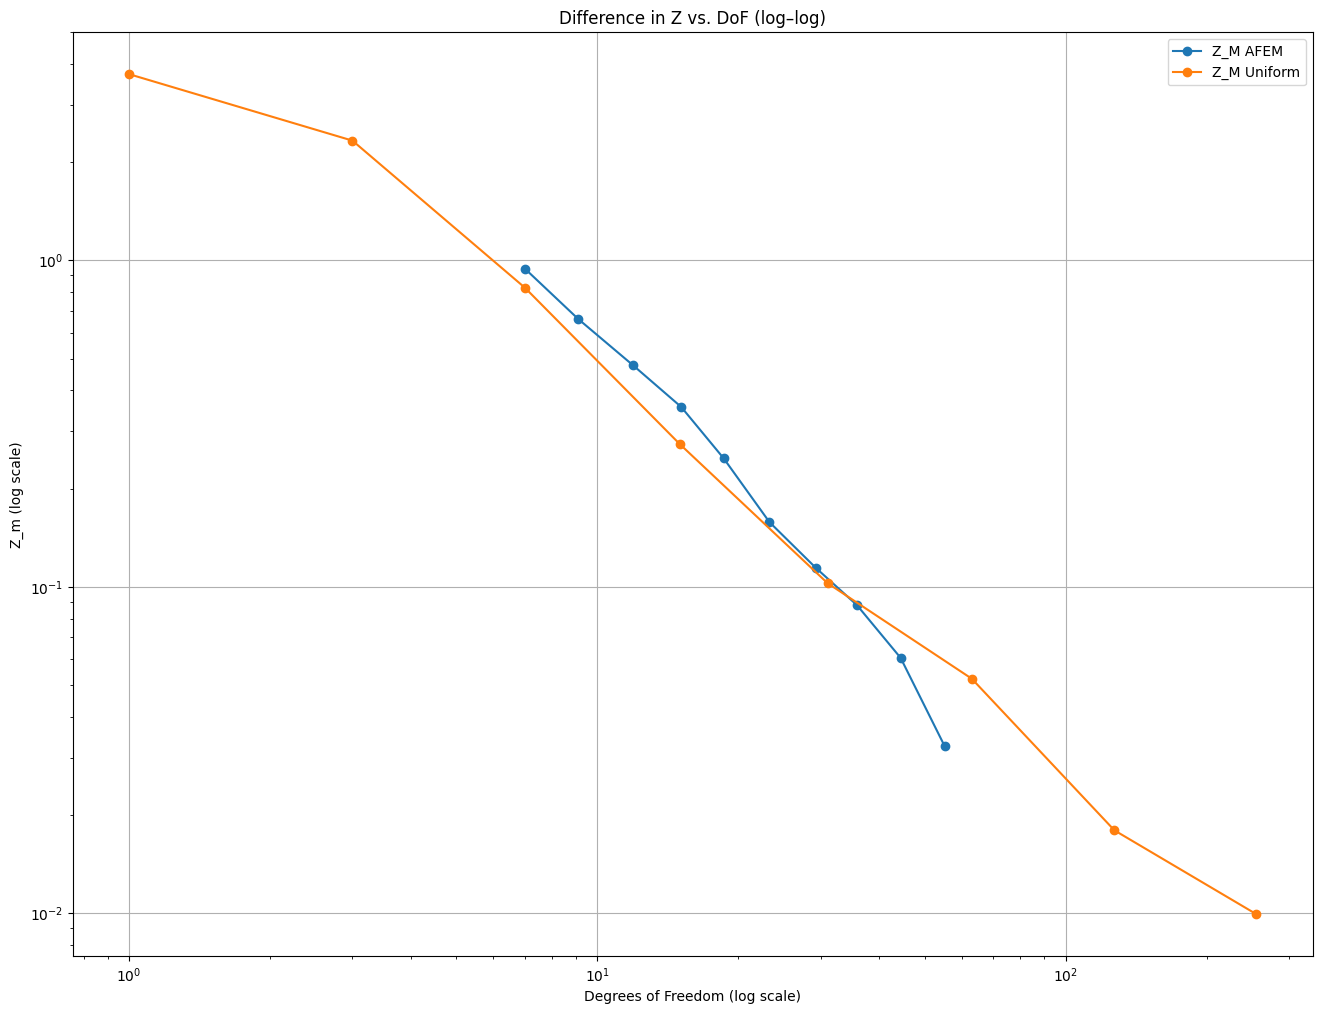

In [13]:


# afem_slope, afem_intercept = np.polyfit(np.log(dof_vals), np.log(diff_in_z_afem_vals), 1)
# fit_afem = np.exp(afem_intercept)*np.power(dof_vals, afem_slope)

# uni_slope, uni_intercept = np.polyfit(np.log(dof_vals_uniform), np.log(diff_in_z_uniform_vals), 1)
# fit_uni = np.exp(uni_intercept)*np.power(dof_vals_uniform, uni_slope)


plt.figure(figsize=(16,12))
plt.loglog(dof_vals, diff_in_z_afem_vals, 'o-', label='Z_M AFEM')
plt.loglog(dof_vals_uniform, diff_in_z_uniform_vals, 'o-', label = 'Z_M Uniform')
plt.xlabel('Degrees of Freedom (log scale)')
plt.ylabel('Z_m (log scale)')
plt.title('Difference in Z vs. DoF (log–log)')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
log_dof_afem = np.log(dof_vals)
log_H_afem   = np.log(H_afem_vals)
slope_afem, intercept_afem = np.polyfit(log_dof_afem, log_H_afem, 1)
H_fit = np.exp(intercept_afem) * (dof_vals**slope_afem)

log_dof_uniform = np.log(dof_vals_uniform)
log_H_uniform = np.log(H_vals_uniform)
slope_uniform, intercept_uniform = np.polyfit(log_dof_uniform, log_H_uniform, 1)
H_uniform_fit = np.exp(intercept_uniform) * (dof_vals_uniform **slope_uniform)

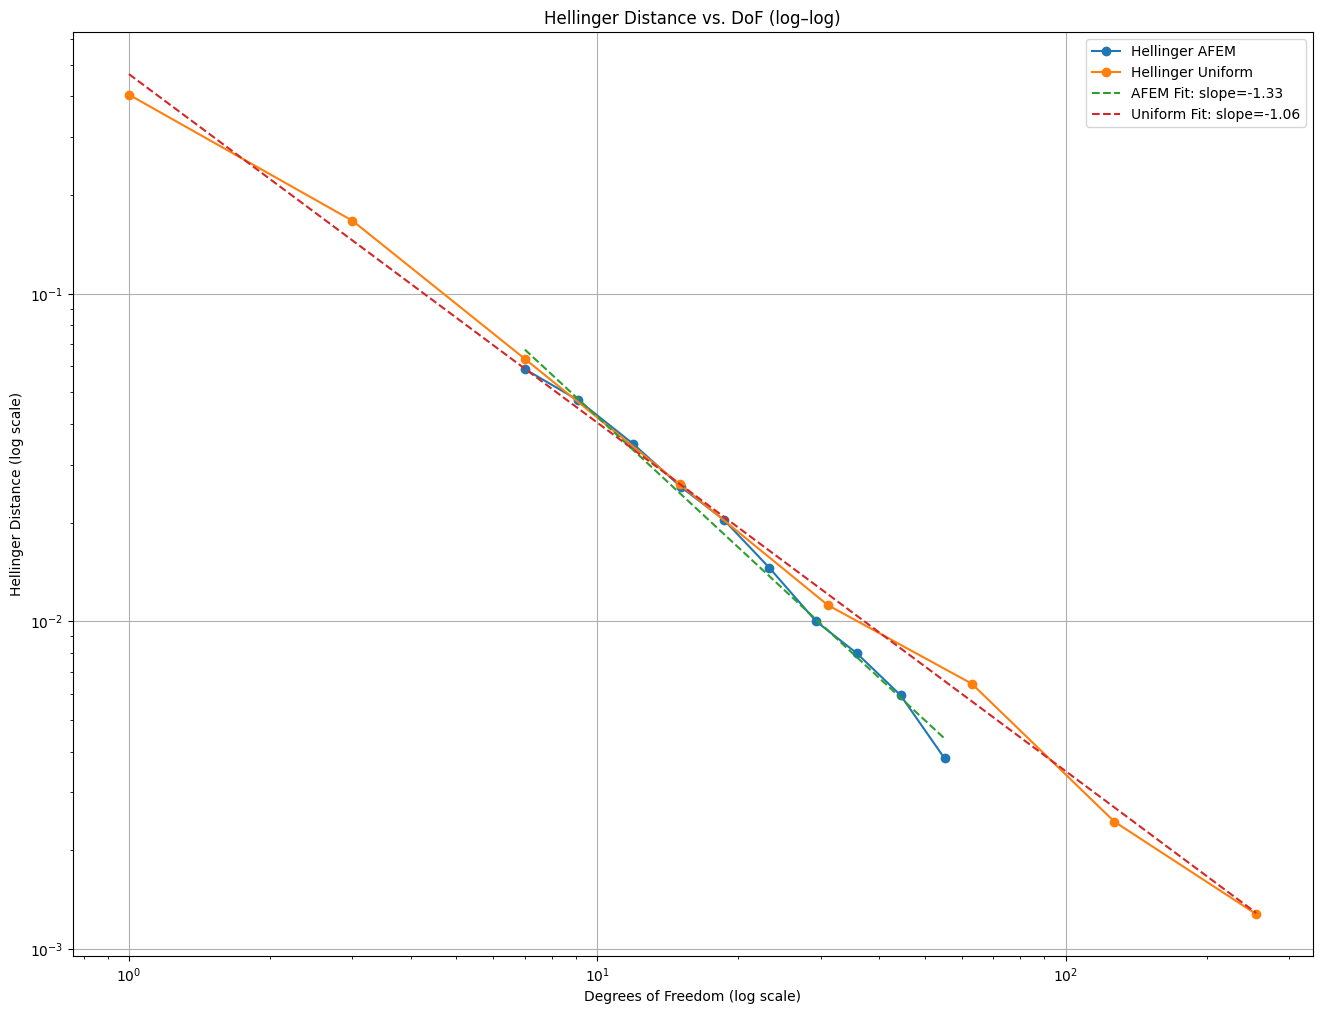

In [16]:
plt.figure(figsize=(16,12))
plt.loglog(dof_vals, H_afem_vals, 'o-', label='Hellinger AFEM')
plt.loglog(dof_vals_uniform, H_vals_uniform, 'o-', label = 'Hellinger Uniform')
plt.loglog(dof_vals, H_fit, '--', label=f'AFEM Fit: slope={slope_afem:.2f}')
plt.loglog(dof_vals_uniform, H_uniform_fit, '--', label=f'Uniform Fit: slope={slope_uniform:.2f}' )
plt.xlabel('Degrees of Freedom (log scale)')
plt.ylabel('Hellinger Distance (log scale)')
plt.title('Hellinger Distance vs. DoF (log–log)')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# num_quad_points = 20
# xi, ci = np.polynomial.legendre.leggauss(num_quad_points)
# r_min, r_max = 0.1, 0.4
# r_nodes = 0.5 * (xi + 1) * (r_max - r_min) + r_min

# print("Gauss–Legendre parameter nodes:", r_nodes)

# def gather_error_afem(M_list, r_star, delta, z_ref):
#     """
#     For each M in M_list, run AFEM once, then compute the error
#     at the single parameter r_star.
#     """
#     afem_dofs = []
#     afem_errors = []
#     afem_G_m = []
#     afem_difference_Z = []

#     for M in M_list:
#         # 1) Build final mesh with M refinements
#         mesh_m, c_sol_m, ddof_list_m, final_obs_m, obs_vals_m = refinement_loop2(
#             beta=[0.5, r_star], 
#             num_dorfler=M
#         )

#         # 2) PDE solve on final mesh for r_star (But note, we've effectively done it already)
#         #    If refinement_loop2 doesn't store final c_sol for r_star, you do:
#         # c_sol_r, _ = solve_scF_once(mesh_m, [0.5, r_star])
#         # But presumably c_sol_m is already that solution if your code is consistent.

#         G_m = compute_integral_x_dudx(mesh_m, c_sol_m)

#         # 3) Error
#         err = abs(delta - G_m)
#         afem_errors.append(err)

#         # 4) DoF
#         dof_m = len(mesh_m) - 2
#         afem_dofs.append(dof_m)

#         # 5) G_m 
#         afem_G_m.append(abs(G_m))

#         # 6) z_M 
#         phi_M = phi_scalar_parametric(mesh_m, obs_scalar, sigma)
#         z_m_afem = compute_normalising_constant(I,phi_M, 20)
#         diff_in_z = z_ref - z_m_afem
#         afem_difference_Z.append(diff_in_z)
        

#     return afem_dofs, afem_errors, afem_G_m, afem_difference_Z
# def gather_error_uniform(l_list, r_star, delta, z_ref):
#     """
#     For each uniform level l in l_list,
#     build a mesh of size 2^l + 1, solve PDE for r_star, compute error.
#     """
#     uniform_dofs = []
#     uniform_errors = []
#     uniform_G_u = []
#     uniform_diff_in_z = []

#     for l in l_list:
#         # 1) Build uniform mesh
#         mesh_u = np.linspace(0, 1, 2**l + 1)

#         # 2) PDE solve
#         c_sol_u, _ = solve_scF_once(mesh_u, [0.5, r_star])

#         # 3) Integral
#         G_u = compute_integral_x_dudx(mesh_u, c_sol_u)

#         # 4) Error
#         err = abs(delta - G_u)
#         uniform_errors.append(err)

#         # 5) DoF
#         dof_u = len(mesh_u) - 2
#         uniform_dofs.append(dof_u)

#         uniform_G_u.append(abs(G_u))

#         phi_l = phi_scalar_parametric(mesh_u, obs_scalar, sigma)
#         z_m_uniform = compute_normalising_constant(I, phi_l, 20)
#         diff_in_z_uniform = z_ref - z_m_uniform
#         uniform_diff_in_z.append(diff_in_z_uniform)

#     return uniform_dofs, uniform_errors, uniform_G_u, uniform_diff_in_z
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_error_one_r(M_list, l_list, r_star):

#     # 2) gather AFEM error
#     afem_dofs, afem_errors, afem_G_m, afem_diff_in_z = gather_error_afem(M_list, r_star, obs_scalar, z_ref)

#     # 3) gather uniform error
#     uniform_dofs, uniform_errors, uniform_G_u, uniform_diff_in_z = gather_error_uniform(l_list, r_star, obs_scalar, z_ref)

#     # 4) log–log plot
#     plt.figure(figsize=(16,12))
#     plt.loglog(afem_dofs, afem_diff_in_z, 'o--', label='AFEM')
#     plt.loglog(uniform_dofs, uniform_diff_in_z, 's--', label='Uniform')

#     #optional: best-fit lines
#     if len(afem_dofs) >= 2:
#         slope_afem, intercept_afem = np.polyfit(np.log(afem_dofs).flatten(), np.log(afem_diff_in_z).flatten(), 1)
#         fit_afem = np.exp(intercept_afem) * (afem_dofs**slope_afem)
#         plt.loglog(afem_dofs, fit_afem, 'k--', label=f'AFEM fit slope={slope_afem:.2f}')
#     if len(uniform_dofs) >= 2:
#         slope_uni, intercept_uni = np.polyfit(np.log(uniform_dofs).flatten(), np.log(uniform_errors).flatten(), 1)
#         fit_uni = np.exp(intercept_uni) * (uniform_dofs**slope_uni)
#         plt.loglog(uniform_dofs, fit_uni, 'k:', label=f'Uniform fit slope={slope_uni:.2f}')

#     plt.xlabel('Degrees of Freedom (log scale)')
#     #plt.ylabel(f'Error |delta - G(r*)| (log scale)')
#     plt.ylabel("Difference In Z: z_ref - z_m")
#     plt.title(f'Error vs. DoF at r={r_star:.3f}')
#     plt.legend()
#     plt.grid(True)
#     plt.show()
